# Bernoulli Mixture Model: Theory

To train a Bernoulli Mixture Model, the formulae are:

- Expectation step

$$z_{n, k} \leftarrow \frac{\pi_k \prod_{i = 1}^D \mu_{k, i}^{x_{n, i}} (1 - \mu_{k, i})^{1 - x_{n, i}} }{\sum_{m = 1}^K \pi_m \prod_{i = 1}^D \mu_{m, i}^{x_{n, i}} (1 - \mu_{m, i})^{1 - x_{n, i}}}$$

- Maximization step

$$\mathbf{\mu_m} \leftarrow \mathbf{\bar{x}_m}$$

$$\pi_m \leftarrow \frac{N_m}{N}$$

where $\mathbf{\bar{x}_m} = \frac{1}{N_m} \sum_{n = 1}^N z_{n, m} \mathbf{x_n}$ and $N_m = \sum_{n = 1}^N z_{n, m}$

# BMM Implementation

**(1)** see `bmm.py` for the complete implementation of the BMM

In [1]:
# settings

data_path = '/home/data/ml/mnist'
k = 21

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import bmm

In [3]:
# loading the data
from mnist import load_mnist

data, labels = load_mnist(dataset='training', path=data_path)

# pre-processing the data (reshape + making it binary)

data = np.reshape(data, (60000, 784))
data = np.where(data > 0.5, 1, 0)

In [4]:
# creating our model
model = bmm.bmm(k, data, 784)

In [5]:
model.fit()

iteration 1 - llk = -11709.346104954391
iteration 2 - llk = -2653.55561995606
iteration 3 - llk = -2471.5858022635184
iteration 4 - llk = -2383.1344402503
iteration 5 - llk = -2342.7350095671445
iteration 6 - llk = -2313.3987423205836
iteration 7 - llk = -2285.8734525313503
iteration 8 - llk = -2259.6573105628195
iteration 9 - llk = -2240.8610459652446
iteration 10 - llk = -2228.861254228615


**(2)** Plot of the means of the learnt mixture

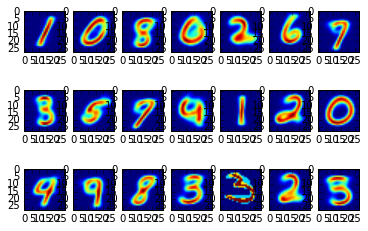

In [6]:
# plotting the means of the learnt mixture

fig = plt.figure()

for k in range(model.k):
    plt.subplot(3, 7, k + 1)
    plt.imshow(model.plot_mu(k))

**(3)** It is not possible to have one center per class with only 10 components even though there are only 10 different digits. Multiple components can represent the same digits (as we can see from the plot). When this happens, it is not possible to represent all of them.

It is possible to avoid this by initializing each component's $\mu_k$ to the mean of the corresponding digit calculated from the labelized dataset. But then it becomes **supervised** learning, which is not what we want.

Here is the result with this kind of initialization:

iteration 1 - llk = -1160.2251650722148
iteration 2 - llk = -1138.121362889474
iteration 3 - llk = -1133.356879773248
iteration 4 - llk = -1131.9787719703945
iteration 5 - llk = -1130.5345612392255
iteration 6 - llk = -1128.1088290686105
iteration 7 - llk = -1125.7975956454404
iteration 8 - llk = -1124.1440618661745
iteration 9 - llk = -1122.987620748402
iteration 10 - llk = -1121.9773474262831


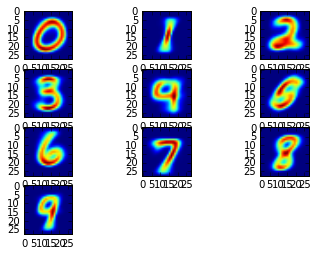

In [7]:
model = bmm.bmm(10, data, 784)
model.data_classes_mean_init(labels)
model.fit()

fig = plt.figure()

for k in range(model.k):
    plt.subplot(4, 3, k + 1)
    plt.imshow(model.plot_mu(k))